In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
import xml.etree.ElementTree as ET
import time
import json
import tarfile
import gzip
import os

from data_preprocessing import * 
from imdb_ratings_scraper import *
import load_functions as lf

import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
import pickle


In [4]:
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)
plot_summaries = pd.merge(plot_summaries, movie_metadata, on="wiki_movie_id", how='left')


In [5]:
#number of nan in movie_name
print("Number of nan's in movie_name {}".format(plot_summaries.movie_name.isna().sum()))
#number of nan in release_date
print("Number of nan's in movie_name {}".format(plot_summaries.release_date.isna().sum()))

Number of nan's in movie_name 99
Number of nan's in movie_name 2717


In [6]:
#amount of plots
print(len(plot_summaries))

42303


In [7]:
plots = plot_summaries["plot"]

In [8]:
plots_list = list(plots)
plots_list_test = plots_list[:500]

At the moment, don't filter out short plots yet

In [9]:
nlp = spacy.load('en_core_web_sm')

In [147]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
STOPWORDS.add("film")
STOPWORDS.add("tell")

processed_plots_1 = list()
for doc in nlp.pipe(plots_list, n_process=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities
    
    # All people's names
    people = [ent.text for ent in ents if ent.label_=="PERSON"]
    
    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation, remove stopwords and remove one-word people's names
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.text not in people]
    
    # Remove common words from a stopword list, keep only words of length 3 or more and casefolding
    doc = [token.casefold() for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity).casefold() for entity in ents if len(entity) > 1])
    
    processed_plots_1.append(doc)


In [150]:
with open('processed_plots_1_full.pickle', 'wb') as f:
    pickle.dump(processed_plots_1, f)

In [140]:
#print(plots_list[3])
test_plot = nlp(plots_list[3])
people = [ent.text for ent in test_plot.ents if ent.label_=="PERSON"]
test_proc = [token.lemma_ for token in test_plot if token.is_alpha and not token.is_stop and token.text not in people]
#print(test_proc)

In [146]:
#print(processed_plots_1[1])

In [151]:
# Add bigrams too
from gensim.models.phrases import Phrases
import copy

#UNCOMMENT IF NOT NECESSARY TO RERUN CELL ABOVE
#with open('processed_plots_1_full.pickle', 'rb') as f:
#         processed_plots_1_full = pickle.load(f)

processed_plots_2 = copy.deepcopy(processed_plots_1)

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(processed_plots_2, min_count=20)

for idx in range(len(processed_plots_2)):
    for token in bigram[processed_plots_2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            processed_plots_2[idx].append(token)

# also add trigrams
#trigram = Phrases(bigram[processed_plots], min_count=15, threshold=100) 
#for idx in range(len(processed_plots)):
#    for token in trigram[bigram[processed_plots[idx]]]:
#        if token.count('_') == 2:
#            # Token is a trigram, add to document.
#            processed_plots[idx].append(token)
#            #print("trigram {} added".format(token))

with open('processed_plots_2_full.pickle', 'wb') as f:
    pickle.dump(processed_plots_2, f)


In [13]:
#UNCOMMENT IF NOT NECESSARY TO RERUN CELL ABOVE
with open('processed_plots_2_full.pickle', 'rb') as f:
         processed_plots_2 = pickle.load(f)

In [14]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(processed_plots_2)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.33
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in processed_plots_2]
#MmCorpus.serialize("models/corpus.mm", corpus)


The words "tell", "film" and "kill" occur in about 30 % of the plots. However, I would think tell and film are not relevant to charactarize the plot, whereas kill is relevent. So should maybe not try to put max_freq parameter in filter_extremes too low to filter out "film" and "tell", but filter those out manually.

In [15]:
# models
seed = 42
from gensim.models import LdaMulticore

params = {'passes': 20, 'random_state': seed}
base_models = dict()
model1 = LdaMulticore(corpus=corpus, num_topics=6, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [16]:
model1.show_topics(num_words=8)

[(0,
  '0.015*"kill" + 0.013*"police" + 0.008*"murder" + 0.006*"money" + 0.006*"shoot" + 0.005*"gang" + 0.004*"car" + 0.004*"escape"'),
 (1,
  '0.010*"war" + 0.007*"kill" + 0.006*"soldier" + 0.005*"army" + 0.004*"force" + 0.004*"order" + 0.004*"return" + 0.004*"american"'),
 (2,
  '0.007*"house" + 0.007*"try" + 0.006*"run" + 0.006*"kill" + 0.005*"come" + 0.005*"room" + 0.005*"night" + 0.005*"away"'),
 (3,
  '0.010*"love" + 0.008*"father" + 0.008*"life" + 0.007*"family" + 0.007*"friend" + 0.006*"mother" + 0.005*"day" + 0.005*"meet"'),
 (4,
  '0.007*"team" + 0.006*"ship" + 0.004*"destroy" + 0.004*"world" + 0.004*"new" + 0.004*"crew" + 0.004*"earth" + 0.004*"time"'),
 (5,
  '0.007*"king" + 0.005*"fight" + 0.004*"story" + 0.004*"kill" + 0.004*"return" + 0.003*"band" + 0.003*"help" + 0.003*"father"')]

Using six topics seems quite interpretable!

In [17]:
base_models = dict()
model2 = LdaMulticore(corpus=corpus, num_topics=8, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [18]:
model2.show_topics(num_words=10)

[(0,
  '0.012*"kill" + 0.011*"police" + 0.008*"money" + 0.007*"shoot" + 0.006*"gang" + 0.005*"car" + 0.005*"steal" + 0.005*"escape" + 0.005*"gun" + 0.004*"try"'),
 (1,
  '0.011*"war" + 0.009*"kill" + 0.006*"soldier" + 0.006*"officer" + 0.005*"police" + 0.005*"army" + 0.005*"german" + 0.005*"prison" + 0.004*"force" + 0.004*"british"'),
 (2,
  '0.008*"try" + 0.007*"run" + 0.006*"house" + 0.006*"come" + 0.005*"away" + 0.005*"car" + 0.005*"head" + 0.005*"dog" + 0.005*"room" + 0.004*"look"'),
 (3,
  '0.012*"love" + 0.009*"father" + 0.008*"friend" + 0.008*"family" + 0.008*"life" + 0.007*"mother" + 0.006*"marry" + 0.006*"meet" + 0.006*"day" + 0.006*"come"'),
 (4,
  '0.008*"team" + 0.006*"ship" + 0.005*"destroy" + 0.005*"earth" + 0.005*"attack" + 0.004*"kill" + 0.004*"world" + 0.004*"crew" + 0.004*"time" + 0.004*"force"'),
 (5,
  '0.009*"new" + 0.008*"play" + 0.007*"story" + 0.006*"movie" + 0.005*"life" + 0.005*"character" + 0.005*"star" + 0.004*"band" + 0.004*"york" + 0.004*"new_york"'),
 (6,

also 8 topics..

In [19]:
base_models = dict()
model3 = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [20]:
model3.show_topics(num_words=8)

[(0,
  '0.013*"kill" + 0.010*"money" + 0.008*"police" + 0.008*"shoot" + 0.008*"gang" + 0.006*"town" + 0.006*"gun" + 0.005*"steal"'),
 (1,
  '0.010*"police" + 0.010*"kill" + 0.007*"murder" + 0.007*"officer" + 0.006*"agent" + 0.006*"prison" + 0.005*"escape" + 0.005*"drug"'),
 (2,
  '0.008*"run" + 0.008*"try" + 0.007*"car" + 0.007*"come" + 0.007*"house" + 0.006*"dog" + 0.006*"away" + 0.006*"head"'),
 (3,
  '0.008*"friend" + 0.007*"love" + 0.007*"school" + 0.006*"life" + 0.006*"new" + 0.005*"day" + 0.005*"meet" + 0.005*"father"'),
 (4,
  '0.012*"team" + 0.008*"game" + 0.005*"world" + 0.005*"plane" + 0.005*"win" + 0.005*"united" + 0.004*"play" + 0.004*"states"'),
 (5,
  '0.009*"new" + 0.008*"story" + 0.006*"york" + 0.005*"new_york" + 0.005*"play" + 0.005*"band" + 0.005*"movie" + 0.005*"life"'),
 (6,
  '0.009*"king" + 0.005*"return" + 0.004*"father" + 0.004*"prince" + 0.004*"fall" + 0.004*"young" + 0.004*"help" + 0.004*"princess"'),
 (7,
  '0.012*"kill" + 0.008*"house" + 0.007*"body" + 0.007

Maybe 10 topics starts to become a bit less interpretable?

# Some evaluation

# The avengers

In [21]:
plot_summaries[plot_summaries['movie_name'].str.contains('avengers', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
10574,8619888,A battle with Ultron leaves The Avengers defea...,/m/027bb0p,Next Avengers: Heroes of Tomorrow,2008-09-02,NaN,78.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04pbhw"": ""Superhero movie"", ""/m/0btmb"": ""..."
10611,10603679,The insidious Masked Gang of hired killers hav...,/m/02qjzb5,Masked Avengers,1981-05-15,NaN,92.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/03h64"": ""Hong Kong""}","{""/m/02kdv5l"": ""Action"", ""/m/04t2t"": ""Martial ..."
13596,12752698,"The Elusive Avengers, a posse of young Red Par...",/m/02x3b43,The Crown of the Russian Empire/Once again the...,1971,NaN,NaN,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union""}","{""/m/02kdv5l"": ""Action"", ""/m/02p0szs"": ""Histor..."
18135,633411,"The film opens with John Steed , agent of The ...",/m/02ywwy,The Avengers,1998-08-14,4.858542e+07,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03k9fj"": ""Advent..."
18937,12752223,The movie continues the story of the Elusive A...,/m/02x39k6,The New Adventures of the Elusive Avengers,1968,NaN,82.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l..."
21233,1624537,The film' is a comedy version of a story about...,/m/05hl9f,The Elusive Avengers,1966,NaN,78.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03k9fj"": ""Adventure"", ""/m/03q4nz"": ""World..."
27482,2952825,"In the last days of World War II in Europe, Ca...",/m/08ftgk,Ultimate Avengers,2006-02-21,NaN,71.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l..."
34940,4644216,"T'Challa, the Prince of Wakanda, returns home ...",/m/0cf6dx,Ultimate Avengers 2,2006-08-08,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/04pbhw"": ""..."
37608,22114132,"The Asgardian Loki encounters the Other, the ...",/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."


Model with 6 topics

In [22]:
print(sorted(model1[corpus[37608]],key=lambda x:x[1],reverse=True))

[(4, 0.99732876)]


Topic with "team", "ship", "attack" is most important, very interpretable

Model with 8 topics

In [23]:
print(sorted(model2[corpus[37608]],key=lambda x:x[1],reverse=True))

[(4, 0.99720126)]


Still same topic,...

Model with 10 topics

In [24]:
print(sorted(model3[corpus[37608]],key=lambda x:x[1],reverse=True))

[(9, 0.87190324), (5, 0.12554148)]


Becomes more dispersed,...

# Lord of the rings

In [25]:
plot_summaries[plot_summaries['movie_name'].str.contains('Lord of the rings', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
14529,173941,"In the Second Age, the Dark Lord Sauron attem...",/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
16411,396607,"Early in the Second Age of Middle-earth, elven...",/m/023cjg,The Lord of the Rings,1978-11-15,3.047142e+07,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/0520_c..."
40429,173944,Gandalf the Grey gives his life in battle agai...,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
41926,174251,"Gandalf, Aragorn, Legolas, Gimli, Théoden, Ga...",/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."


6 topics

In [26]:
print(sorted(model1[corpus[41926]],key=lambda x:x[1],reverse=True))

[(1, 0.60774773), (5, 0.25832066), (2, 0.09071467), (4, 0.041999146)]


8 topics

In [27]:
print(sorted(model2[corpus[41926]],key=lambda x:x[1],reverse=True))

[(6, 0.9473615), (7, 0.049923528)]


10 topics

In [28]:
print(sorted(model3[corpus[41926]],key=lambda x:x[1],reverse=True))

[(9, 0.64875644), (6, 0.20333779), (2, 0.06200239), (8, 0.061499096), (7, 0.022587039)]


Saving private ryan

In [29]:
plot_summaries[plot_summaries['movie_name'].str.contains('Private ryan', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
5103,28269,"On the morning of June 6, 1944, the beginning ...",/m/07024,Saving Private Ryan,1998-07-24,481840909.0,169.0,"{""/m/064_8sq"": ""French Language"", ""/m/01wgr"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n0w"": ""Ensemble Film"", ""/m/03g3w"": ""H..."


In [30]:
print(sorted(model1[corpus[5103]],key=lambda x:x[1],reverse=True))

[(1, 0.8354927), (2, 0.08618592), (4, 0.068386026)]


In [31]:
print(sorted(model2[corpus[5103]],key=lambda x:x[1],reverse=True))

[(1, 0.61822945), (4, 0.18029915), (0, 0.104356766), (2, 0.05211797), (3, 0.044041764)]


## Adding all BoW and distribution over topics to each movie entry in df

In [32]:
plot_summaries["BoW"] = corpus
plot_summaries["6-topic model distibution"] = model1[corpus]
plot_summaries["8-topic model distibution"] = model2[corpus]
plot_summaries["10-topic model distibution"] = model3[corpus]

In [33]:
plot_summaries.head()

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,BoW,6-topic model distibution,8-topic model distibution,10-topic model distibution
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(3, 0.95064074)]","[(3, 0.88007146), (5, 0.07566158)]","[(3, 0.54360473), (8, 0.40925515)]"
1,31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[(8, 2), (15, 1), (16, 1), (17, 1), (18, 1), (...","[(0, 0.05787356), (1, 0.20546827), (2, 0.26919...","[(0, 0.07570184), (1, 0.07835326), (2, 0.14340...","[(0, 0.040058024), (1, 0.12655884), (2, 0.0547..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[(8, 1), (40, 1), (45, 1), (69, 1), (70, 2), (...","[(0, 0.3609876), (1, 0.17240457), (3, 0.464357...","[(1, 0.46250603), (3, 0.30492622), (7, 0.22624...","[(1, 0.31924433), (8, 0.67719024)]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[(19, 1), (26, 1), (37, 1), (39, 1), (40, 1), ...","[(0, 0.5064325), (2, 0.19239508), (3, 0.271694...","[(0, 0.5091604), (2, 0.22384503), (3, 0.219614...","[(0, 0.4450004), (2, 0.112753585), (3, 0.34012..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[(0, 1), (5, 1), (22, 1), (44, 1), (45, 1), (4...","[(0, 0.34935227), (1, 0.23272605), (2, 0.26804...","[(1, 0.41322204), (2, 0.16348597), (3, 0.03473...","[(1, 0.4027351), (2, 0.026082894), (3, 0.08517..."


Find most representative movies for each topic (in 6-topic model)

In [34]:
def get_topic_value(distr, query_topic):
    
    for (topic, prob) in distr:
        if query_topic == topic:
            return prob
    return 0

most_repr_movies_per_topic = dict()
for topic in range(0,6):
    top_10_movies_indices = \
        plot_summaries["6-topic model distibution"].apply(lambda x: get_topic_value(x, topic)).sort_values(ascending=False)[:10].index
    most_repr_movies_per_topic[topic] = \
        plot_summaries.iloc[top_10_movies_indices]["movie_name"]
for topic in range(0,6):
    print("Topic with distribution of words: \n")
    print(model1.show_topics(num_words=8)[topic][1])
    print("\n")
    print("Has most representative movies:")
    print(most_repr_movies_per_topic[topic])
    

Topic with distribution of words: 

0.015*"kill" + 0.013*"police" + 0.008*"murder" + 0.006*"money" + 0.006*"shoot" + 0.005*"gang" + 0.004*"car" + 0.004*"escape"


Has most representative movies:
4927             The Lincoln Lawyer
11080         Chura Liyaa Hai Tumne
38522                Public Enemies
36597                           McQ
38066                  Gang Related
7576                    The Killers
38024                     Appaloosa
38396                  Street Kings
31242                   Blue Streak
37376    Slaughter in San Francisco
Name: movie_name, dtype: object
Topic with distribution of words: 

0.010*"war" + 0.007*"kill" + 0.006*"soldier" + 0.005*"army" + 0.004*"force" + 0.004*"order" + 0.004*"return" + 0.004*"american"


Has most representative movies:
19918                             Taegukgi
39838      The Wind That Shakes the Barley
9643                        Ernst Thälmann
38807                    The Four Feathers
2186     Chetniks! The Fighting Guerrillas


# Analysis of topic evolution per year

In [36]:
plot_summaries["release_year"] = plot_summaries['release_date'].apply(lambda x: lf.extract_year(x))
plot_summaries["release_year"].describe()

count    39586.000000
mean      1983.615394
std         26.114686
min       1010.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

In [37]:
plot_summaries[plot_summaries["release_year"] == 1010]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,BoW,6-topic model distibution,8-topic model distibution,10-topic model distibution,release_year
26304,29666067,Veteran homicide cop Ferman and his hot-heade...,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...","[(129, 1), (319, 1), (348, 1), (353, 1), (410,...","[(0, 0.74791133), (3, 0.23166457)]","[(0, 0.5979924), (5, 0.09133019), (7, 0.291675...","[(1, 0.62705237), (3, 0.22019783), (7, 0.13146...",1010.0


This movie was actually released in 2010...

In [40]:
plot_summaries.loc[26304,["release_date"]] = "2010-12-02"

In [42]:
plot_summaries["release_year"] = plot_summaries['release_date'].apply(lambda x: lf.extract_year(x))

In [43]:
plot_summaries["release_year"].describe()

count    39586.000000
mean      1983.640656
std         25.652430
min       1893.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

In [62]:
def average_per_topic(group, amount_topics=6):
    distributions = group['{}-topic model distibution'.format(amount_topics)]
    averages = np.zeros(amount_topics)
    for distr in distributions:
        for (topic, value) in distr:
            averages[topic] += value
    
    averages = averages/len(distributions)
    
    result = dict()
    for topic in range(amount_topics):
        result["average_topic_{}".format(topic)] = averages[topic]
    
    return pd.Series(result)

plots_year = plot_summaries.groupby(["release_year"]).apply(average_per_topic)
plots_year['movie_count'] = plot_summaries.groupby(['release_year']).apply(lambda x: len(x))

In [194]:
# get list of 5 most important words for each topic
words_per_topic = []
amount_topics = 6
for topic in range(0,amount_topics):
    topic_words = [word for (word, _) in model1.show_topic(topic, 5)]
    topic_words = ", ".join(topic_words)
    words_per_topic.append(topic_words)


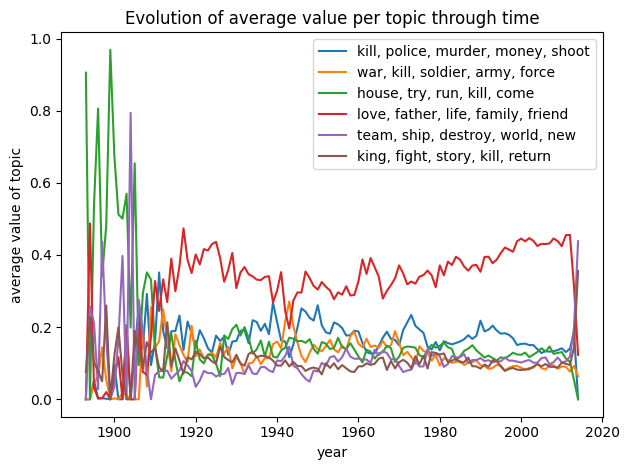

In [59]:
for topic in range(0,6):
    plt.plot(plots_year.index, plots_year["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

Lets look at the amount of movies in each year to get a clearer sense of from which years we have enough data

Text(0.5, 1.0, 'Amount of movies in each year')

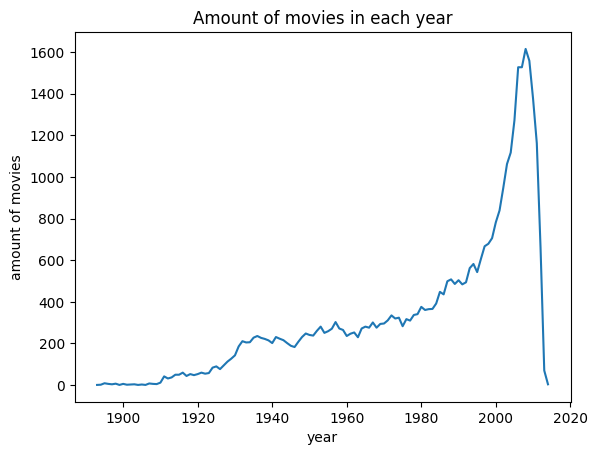

In [64]:
plt.plot(plots_year.index, plots_year.movie_count)
plt.xlabel("year")
plt.ylabel("amount of movies")
plt.title("Amount of movies in each year")

Let's look at the period 1960 to 2009

Text(0.5, 1.0, 'Amount of movies in each year')

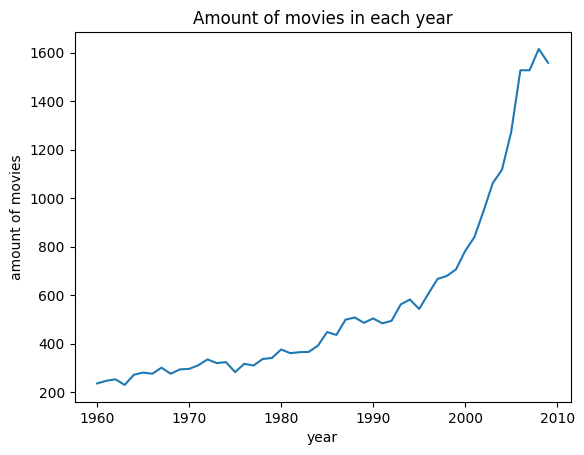

In [66]:
plots_year_60_09 = plots_year[1960:2009]
plt.plot(plots_year_60_09.index, plots_year_60_09.movie_count)
plt.xlabel("year")
plt.ylabel("amount of movies")
plt.title("Amount of movies in each year")

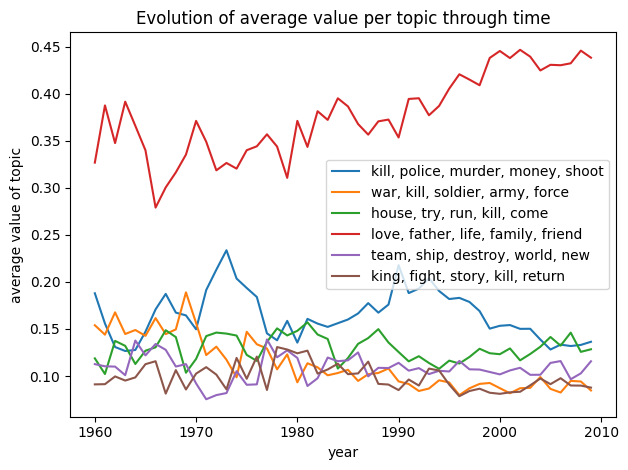

In [69]:
for topic in range(0,6):
    plt.plot(plots_year_60_09.index, plots_year_60_09["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

Now instead of averaging over one year, let's average over a period of five years

In [141]:
def weighted_avg(group, amount_topics=6):
    result = dict()
    for topic in range(amount_topics):
        # weighted average by amount of movies in year, this year every movie in time period contributes the same amount
        weighted_sum = sum(group["average_topic_{}".format(topic)]*group.movie_count)
        total_movies = sum(group.movie_count)
        result["average_topic_{}".format(topic)] = weighted_sum/total_movies if total_movies else 0
    return pd.Series(result)

plots_year["period"] = (plots_year.index//5)*5
plots_5year = plots_year.groupby("period").apply(weighted_avg)

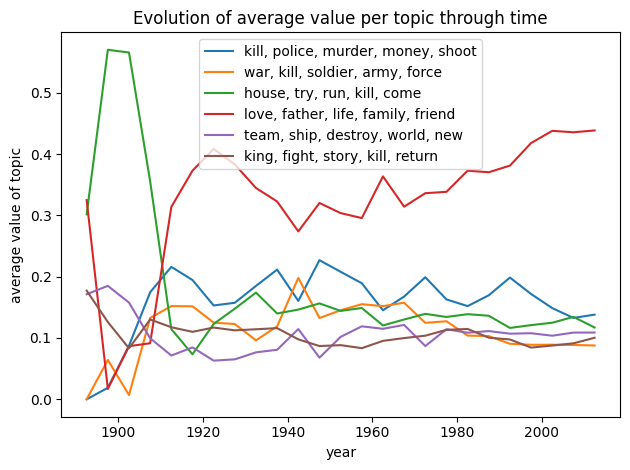

In [142]:
for topic in range(0,6):
    plt.plot(plots_5year.index + 2.5, plots_5year["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

Let's look again at the period 1960 to 2009

In [143]:
plots_5year_60_09 = plots_5year.loc[1960:2009]

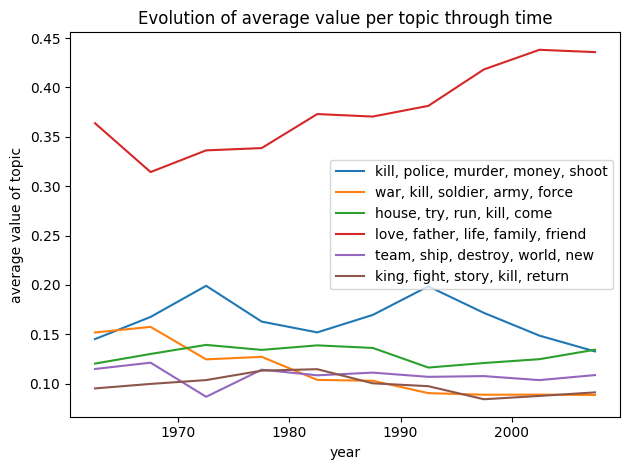

In [144]:
for topic in range(0,6):
    plt.plot(plots_5year_60_09.index + 2.5, plots_5year_60_09["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

One thing we are not taking into account is the popularity of a movie. In the previous plots, the plain average of the topic distributions is taken for each time period. However, to better capture which topics were popular in movies in which time periods, it might be a better idea to take the popularity of each movie into account. One proxy for popularity is the box office revenue, which we will use here. We will also again look at time periods of 5 years.

In [145]:
# First filter out all movies without a box office revenue value (we assume they are missing completely at random)
plot_summaries_filt = plot_summaries[plot_summaries["box_office_revenue"].notna()]

# add period
plot_summaries_filt["period"] = (plot_summaries_filt["release_year"]//5)*5

/var/folders/t8/93t01cl96px6ff55chv5jznw0000gn/T/ipykernel_66020/3743660159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_filt["period"] = (plot_summaries_filt["release_year"]//5)*5


In [146]:
def average_per_topic_weighted(group, amount_topics=6):
    averages = np.zeros(amount_topics)
    for index, movie in group.iterrows():
        for (topic, value) in movie['{}-topic model distibution'.format(amount_topics)]:
            averages[topic] += value * movie.box_office_revenue
    total_box_office = sum(group.box_office_revenue)
    averages = averages / total_box_office if total_box_office else 0
    
    result = dict()
    for topic in range(amount_topics):
        result["average_topic_{}".format(topic)] = averages[topic]
    
    return pd.Series(result)

plots_5year_weighted = plot_summaries_filt.groupby("period").apply(average_per_topic_weighted)

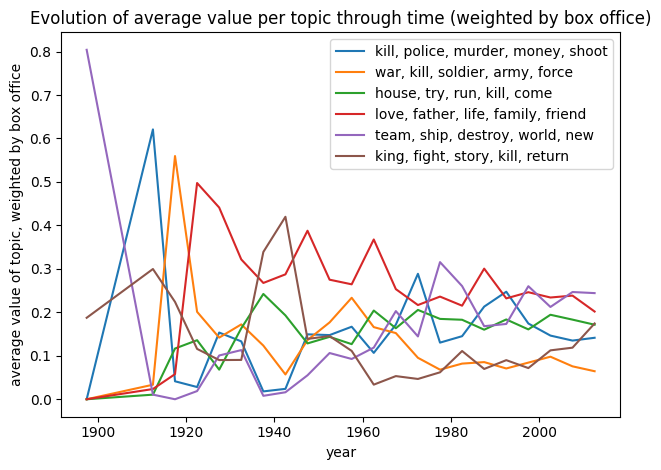

In [147]:
for topic in range(0,6):
    plt.plot(plots_5year_weighted.index + 2.5, plots_5year_weighted["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic, weighted by box office")
plt.title("Evolution of average value per topic through time (weighted by box office)")
plt.tight_layout()

Let's look only the period of 1950 to 2009

In [148]:
plots_5year_weighted_50_09 = plots_5year_weighted.loc[1950:2009]

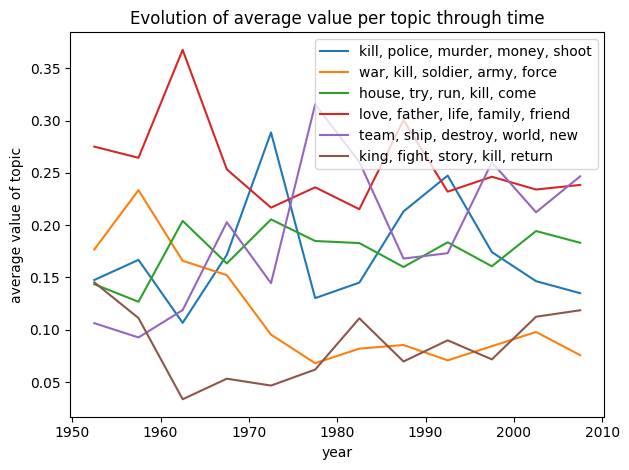

In [149]:
for topic in range(0,6):
    plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

We can see some interesting trends in this plot!
* Evolution of topic with relevent words war, kill, soldier, army, force
When we look at the evolution of the topic that contains mostly words that can be linked to war movies, we see that this topic is still quite relevant in the period 1950-1960. This should be not too surprising, as this is the period right after the world had seen two big wars. It is not surprising that war was still an intriguing concept at that time! We see that as the two big wars became more something of a distant past, the war topic became less prevelant in movies. 
* Evolution of topic with relevent words love, father, life, family, friend
When we look at the evolution of the "love" topic, the first thing that jumps into the eye is the big peak around the year 1960. This is also not surprising if we know the cultural climate of the sixties! The cultural climate of the 1960s was marked by the hippie movement, which embraced values of love, peace, and camaraderie.

To be able to more clearly link the evolution of topics to cultural trends, lets now only look at movies released in the US.

First we do a quick check to see how the US is represented in the dataframe.

In [150]:
list_all_countries = plot_summaries.countries.apply(lambda x: list(eval(x).values()) if not pd.isnull(x) else None)

In [151]:
unique_countries = np.sort(list_all_countries.explode().dropna().unique())

In [152]:
print(unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Belgium' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria'
 'Burkina Faso' 'Burma' 'Cambodia' 'Cameroon' 'Canada' 'Chile' 'China'
 'Colombia' 'Congo' 'Costa Rica' 'Crime' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Czechoslovakia' 'Democratic Republic of the Congo'
 'Denmark' 'Egypt' 'England' 'Estonia' 'Ethiopia'
 'Federal Republic of Yugoslavia' 'Finland' 'France' 'Georgia'
 'Georgian SSR' 'German Democratic Republic' 'German Language' 'Germany'
 'Greece' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Hong Kong' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Iraq' 'Iraqi Kurdistan' 'Ireland'
 'Isle of Man' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kenya'
 'Kingdom of Great Britain' 'Kingdom of Italy' 'Korea' 'Kuwait' 'Lebanon'
 'Libya' 'Lithuania' 'Luxembourg' 'Macau' 'Malayalam Language' 'Malaysia'
 'Mali' 'Malta' 'Mandatory Palestine' 'Mexic

We can see that US is uniquely identified as 'United States of America'

In [207]:
list_all_genres = plot_summaries.genres.apply(lambda x: list(eval(x).values()) if not pd.isnull(x) else None)
unique_genres = np.sort(list_all_genres.explode().dropna().unique())
print(len(unique_genres))
print(unique_genres)

363
['Absurdism' 'Acid western' 'Action' 'Action Comedy' 'Action Thrillers'
 'Action/Adventure' 'Addiction Drama' 'Adult' 'Adventure'
 'Adventure Comedy' 'Airplanes and airports' 'Albino bias' 'Alien Film'
 'Alien invasion' 'Americana' 'Animal Picture' 'Animals'
 'Animated Musical' 'Animated cartoon' 'Animation' 'Anime' 'Anthology'
 'Anthropology' 'Anti-war' 'Anti-war film'
 'Apocalyptic and post-apocalyptic fiction' 'Archaeology'
 'Archives and records' 'Art film' 'Auto racing' 'Avant-garde' 'B-Western'
 'B-movie' 'Backstage Musical' 'Baseball' 'Beach Film' 'Beach Party film'
 'Bengali Cinema' 'Biker Film' 'Biographical film' 'Biography'
 'Biopic [feature]' 'Black comedy' 'Black-and-white' 'Blaxploitation'
 'Bloopers & Candid Camera' 'Bollywood' 'Boxing' 'Breakdance'
 'British Empire Film' 'British New Wave' 'Bruceploitation'
 'Buddy Picture' 'Buddy cop' 'Buddy film' 'Business' 'C-Movie' 'Camp'
 'Caper story' 'Cavalry Film' 'Chase Movie' 'Chick flick'
 'Childhood Drama' "Children's" "

In [153]:
# keep only movies released in US and with box office revenue
movies_released_US = plot_summaries_filt.countries.apply(lambda x: 'United States of America' in eval(x).values() if not pd.isnull(x) else False)
plot_summaries_US = plot_summaries_filt[movies_released_US]


In [154]:
plots_US_5year_weighted = plot_summaries_US.groupby("period").apply(average_per_topic_weighted)
plots_US_5year_weighted_50_09 = plots_US_5year_weighted[1950:2009]

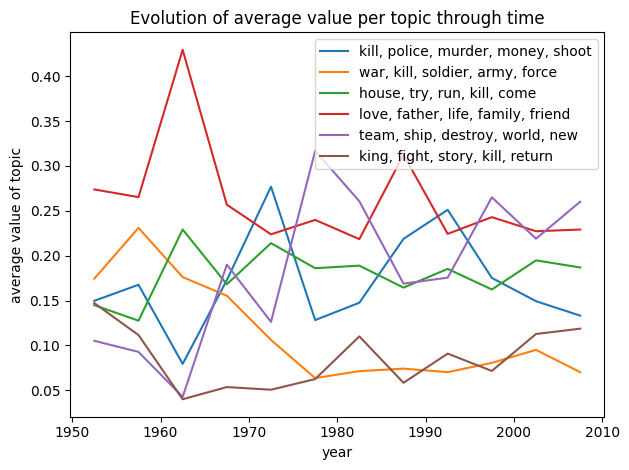

In [155]:
for topic in range(0,6):
    plt.plot(plots_US_5year_weighted_50_09.index + 2.5, plots_US_5year_weighted_50_09["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

Mostly, the same analyses as before hold. For the "love"-topic, we see an even bigger peak around 1960, which makes sense if we take into account the fact that the hippie-movement was very big in the US.

Another interesting analysis that can be made is when we look at the "crime" topic with relevant words kill, police, murder, shoot. We distinctly see two peaks. One around the year 1970 and one around the year 1990. Now look at the following figure displaying the homocide rate (a metric for crime) in the US from 1950 onwards.

![US crime rate](https://www.researchgate.net/profile/James-Fox-12/publication/249718644/figure/fig1/AS:669977313021993@1536746447925/US-Homicide-Rate-1950-1999_W640.jpg)


We see that the crime rate follows a similar pattern, with also peaks in the period 1970-1975 and 1990-95! This further supports the hypothesis that the movie industry is a reflection of the current culture.

Furthermore, we also see an increase in the prevelance of the "superhero" topic with relevant words team, ship, destroy, world, new. This could maybe be attributed to the rise of comic-books being adapted into movies.

## using 8 topics

In [203]:
plots_10topic_5year = plot_summaries_filt.groupby("period").apply(average_per_topic_weighted, amount_topics=10)

In [204]:
plots_10topic_5year50_09 = plots_10topic_5year[1950:2009]

In [205]:
# get list of 5 most important words for each topic
words_per_topic10 = []
amount_topics = 10
for topic in range(0,amount_topics):
    topic_words = [word for (word, _) in model3.show_topic(topic, 5)]
    topic_words = ", ".join(topic_words)
    words_per_topic10.append(topic_words)


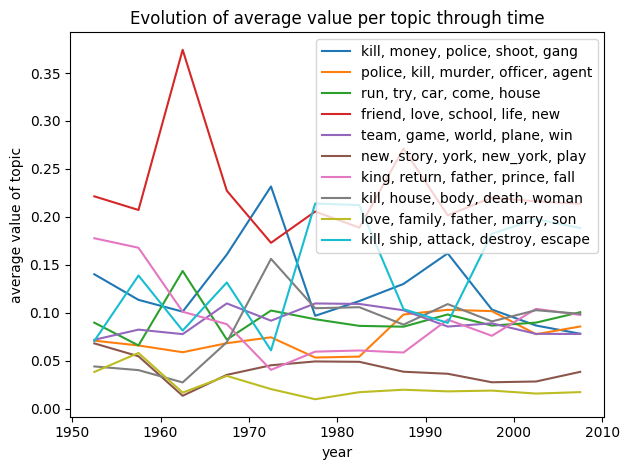

In [206]:
for topic in range(0,amount_topics):
    plt.plot(plots_10topic_5year50_09.index + 2.5, plots_10topic_5year50_09["average_topic_{}".format(topic)], label=words_per_topic10[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

## Plotting movies

In [179]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [186]:

movie_topic_distr = plot_summaries.query("release_year < 2010 and release_year > 2000")["6-topic model distibution"]
data_points = []
for distr in movie_topic_distr:
    new_row = [0,0,0,0,0,0]
    for (topic, value) in distr:
        new_row[topic] = value
    data_points.append(new_row)

data_points = pd.DataFrame(data_points)
#print(data_points)


In [192]:
data_reduced = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(data_points)

In [188]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_points)


/Users/maxsebrechts/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.05503561 0.0587632  0.08213398 0.167317   0.08015003 0.54875677]
[0.05527952 0.03366656 0.05191559 0.77619247 0.03655591 0.03632388]
[0.06176642 0.57564716 0.03957961 0.1826851  0.07608351 0.05595701]
[0.06078736 0.0609148  0.08299622 0.13496089 0.5923557  0.06096506]
[0.07888205 0.02582953 0.5860542  0.18090808 0.06597728 0.05787109]
[0.56364112 0.04698823 0.08100223 0.21811495 0.04074739 0.04253748]


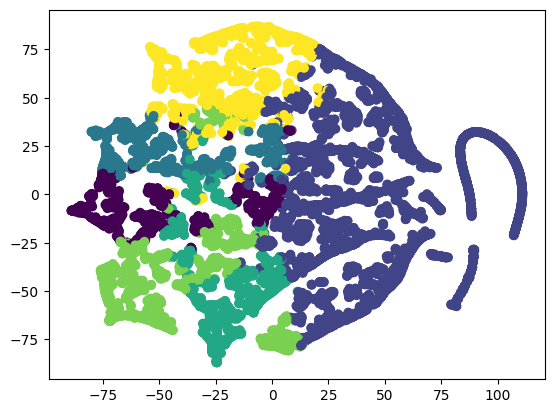

In [193]:


labels = kmeans.predict(data_points)
#data_reduced = pca.transform(data_points)
plt.scatter(data_reduced[:,0], data_reduced[:,1], c=labels)

for c in kmeans.cluster_centers_:
    #c = pca.transform([c])
    #plt.scatter(c[0][0], c[0][1], marker="x", color="red")
    print(c)